In [ ]:

'''
src/
├── rag/
│   ├── __init__.py                    # Initialize the RAG module
│   ├── text_files/
│   │   ├── __init__.py                # Initialize text files processing
│   │   ├── pdf_processor.py           # Handles RAG for PDF files
│   │   ├── docx_processor.py          # Handles RAG for DOCX files
│   │   ├── txt_processor.py           # Handles RAG for TXT files
│   │   └── utils.py                   # Common utilities for text file processing
│   ├── web_links/
│   │   ├── __init__.py                # Initialize web links processing
│   │   ├── web_scraper.py             # Scrapes and preprocesses data from web links
│   │   └── utils.py                   # Common utilities for web links processing
│   ├── github_repo/
│   │   ├── __init__.py                # Initialize GitHub repository processing
│   │   ├── repo_scraper.py            # Extracts and preprocesses data from GitHub repositories
│   │   └── utils.py                   # Common utilities for GitHub repo processing
│   └── rag_pipeline.py                # Combines RAG components into a cohesive pipeline
├── llm/
│   ├── __init__.py                    # Initialize the LLM module
│   ├── openai_integration.py          # Integration with OpenAI models
│   ├── groq_integration.py            # Integration with Groq models
│   ├── llama_integration.py           # Integration with Llama models
│   ├── huggingface_integration.py     # Integration with HuggingFace models
│   ├── api_clients/
│   │   ├── __init__.py                # Initialize API clients
│   │   ├── openai_client.py           # API client for OpenAI
│   │   ├── groq_client.py             # API client for Groq models
│   │   ├── llama_client.py            # API client for Llama models
│   │   ├── huggingface_client.py      # API client for HuggingFace
│   └── llm_pipeline.py                # Combines LLM integrations into a cohesive pipeline
├── utils/
│   ├── __init__.py                    # Initialize the utilities module
│   ├── file_utils.py                  # Generic utilities for file handling
│   ├── web_utils.py                   # Generic utilities for web-related tasks
│   └── data_preprocessing.py          # Common preprocessing tasks for both RAG and LLM
├── config/
│   ├── __init__.py                    # Initialize the configuration module
│   ├── settings.py                    # Central configuration settings
│   ├── secrets.py                     # Store API keys and sensitive information (use environment variables)
└── main.py                            # Main entry point to initialize and run the application

'''


### This is a playground!

Here you can quickly test some code, visualize your data

In [13]:
from langchain_community.embeddings import OpenAIEmbeddings

In [1]:
# import torch
# import torch.nn as nn
import sys
import os
import langchain
from langchain.llms import OpenAI
import dotenv

dotenv.load_dotenv()

os.chdir('..')
os.getcwd()

from src.rag.web_scraper import WebScraper
from src.rag.document_loader import URLDocumentLoader, FileDocumentLoader, GitHubIssuesDocumentLoader, GitHubRepoDocumentLoader, ResearchPapersDocumentLoader
from src.rag.text_splitter import TextSplitter
from src.rag.vector_store import VectorStoreManager
from langchain.text_splitter import RecursiveCharacterTextSplitter, TokenTextSplitter

# GitHub API keys
github_username = os.getenv('GITHUB_USERNAME')
github_personal_token = os.getenv('GITHUB_PERSONAL_TOKEN')

# AI models API keys
openai_api_key = os.getenv('OPENAI_API_KEY')
huggingface_api_key = os.getenv('HUGGINGFACE_API_KEY')
huggingface_api_key_2 = os.getenv('HUGGINGFACE_API_KEY_2')

# Vector Database API keys
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pinecone_index_name = os.getenv('PINECONE_INDEX_NAME')

# Research Papers API keys
elsevier_api_key = os.getenv('ELSEVIER_API_KEY')
ieee_api_key =  os.getenv('IEEE_API_KEY')
elsevier_api_secret = os.getenv('ELSEVIER_API_SECRET')

# MongoDB API keys
mongo_username = os.getenv('MONGO_USERNAME')
mongo_password = os.getenv('MONGO_PASSWORD')
mongo_cluster = os.getenv('MONGO_CLUSTER')
mongo_db = os.getenv('MONGO_DB')
mongo_collections = os.getenv('MONGO_COLLECTIONS')
mongo_app_name = os.getenv('MONGO_APP_NAME')


scraper = WebScraper()
base_url = "https://ou.edu/"
repo_dir = "n8n-io/n8n" # GitHub repository to scrape
repo_url = "https://github.com/obinopaul/licence-plate-detection.git"   # URL of the GitHub repository to scrape
clone_dir = "./data"  # Directory to clone the repository to

query = "What is the best way to detect license plates in images?"


c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [27]:
from src.rag.web_scraper import WebScraper # Import the WebScraper class from the RAG module 

scraper = WebScraper()
base_url = "https://ou.edu/"
repo_dir = "n8n-io/n8n" # GitHub repository to scrape
repo_url = "https://github.com/obinopaul/licence-plate-detection.git"   # URL of the GitHub repository to scrape    
clone_dir = "./data"  # Directory to clone the repository to

# Webscraper API call
result = scraper.api_get_weblinks(base_url=base_url, time_limit=5)

#--------------- document_loader.py ----------------

datasets = URLDocumentLoader(base_url).load_from_urls() # Load data from URLs, takes in a list of URLs from webscraper.py
datasets = FileDocumentLoader().load_from_files([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')]) # Load data from text files
datasets = GitHubIssuesDocumentLoader(access_token=github_personal_token).load_documents(repos=repo_dir) # Load data from GitHub issues 
datasets = GitHubRepoDocumentLoader(repo_urls=repo_url, clone_dir=clone_dir).load_documents_as_dicts()
datasets = ResearchPapersDocumentLoader(
    ieee_api_key = ieee_api_key,
    elsevier_api_key = elsevier_api_key,
).load_documents(query='machine learning', max_results=15, sources=['ieee', 'elsevier', 'arxiv'])


#--------------- text_splitter.py ----------------

splitter = TextSplitter(splitter_type = 'recursive', chunk_size = 1000, chunk_overlap = 200)
# split files into chunks
datas_chunks = splitter.split_file_documents([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')])

# Split url content into chunks
datas_chunks = splitter.split_url_documents(base_url)

# split github issues into chunks
datas_chunks = splitter.split_github_issues_documents(repos=repo_dir, access_token=github_personal_token)

# split github repo content into chunks
datas_chunks = splitter.split_github_repo_documents(repo_urls=repo_url, clone_dir=clone_dir)

# split research papers into chunks
datas_chunks = splitter.split_research_papers_documents(query=query, max_results = 15, 
                                                             sources = ['ieee', 'elsevier', 'arxiv'], ieee_api_key = ieee_api_key,
                                                             elsevier_api_key = elsevier_api_key)




#--------------- vector_store.py ----------------

from src.rag.vector_store import VectorStoreManager
from src.rag.text_splitter import TextSplitter
import os

splitter = TextSplitter(splitter_type = 'recursive', chunk_size = 1000, chunk_overlap = 200)
# split files into chunks
datas_chunks = splitter.split_file_documents([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')])


# Initialize the VectorStoreManager
vector_store_manager = VectorStoreManager(
    vector_store_type="pinecone",
    embedding_type="openai",
    pinecone_api_key=pinecone_api_key,
    pinecone_index_name=pinecone_index_name
)

# Add file chunks to the vector store
vector_store_manager.add_documents(documents=datas_chunks)

query = "What is machine learning?"
search_results = vector_store_manager.search(query=query, top_k=5)

print("Similarity Search Results:")
for result in search_results:
    print(f"Score: {result['score']}")
    print(f"Document: {result['document']}")
    print("---")


# Create a retriever with default settings
retriever = vector_store_manager.as_retriever()

# Create a retriever with custom settings
retriever_with_threshold = vector_store_manager.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        'k': 5,  # Retrieve 5 documents
        'score_threshold': 0.7  # Only return documents with score >= 0.7
    }
)


#--------------- other functions of vector store ---------------------------------------
# Update a document
document_id = "document_id_to_update"
updated_content = "Updated document content"
updated_document = Document(page_content=updated_content)
vector_store_manager.update_document(document_id=document_id, updated_document=updated_document)


# Retrieve a document by ID
retrieved_document = vector_store_manager.get_document_by_id(document_id=document_id)
print(f"Retrieved Document: {retrieved_document.page_content}")

# Delete a document
vector_store_manager.delete_document(document_id=document_id)

# Clear the entire vector store
vector_store_manager.clear_vector_store()

# Get vector store information
vector_store_info = vector_store_manager.get_vector_store_info()
print(f"Vector Store Information: {vector_store_info}")

# List all indexes
indexes = vector_store_manager.list_indexes()
print(f"Indexes: {indexes}")

# Delete the index
vector_store_manager.delete_index()



#--------------- data_validate.py ----------------
from src.data_validate import DataValidator
from pydantic import ValidationError

data_types_examples = ["url", "text", "github_repo_url", "github_repo_text"]
validator = DataValidator()

# EXAMPLE 1: Valid URL
try:
    validated_1 = validator.validate_input(data_type="github_repo_text", data="example.com/docs")
    print("Validated 1:", validated_1)
except ValidationError as e:
    print("Validation Error 1:", e)


#--------------- llm.py ----------------





#--------------- llm_pipeline.py ----------------
from src.llm.llm_pipeline import LLMPipeline

openai_pipeline = LLMPipeline(model_type="openai", api_key=openai_api_key, temperature=0.7)
openai_pipeline.chatbot.create_retrieval_qa_chain(retriever=retriever)

openai_response = openai_pipeline.run("What's the capital of France?")
print("OpenAI Response:")
print(openai_response)

query = "What are the main advantages of using Python for data science?"
rag_response = openai_pipeline.generate_response(query, retriever)
print("Retrieval-Augmented Generation Response:")
print(rag_response)

rag_response_with_sources = openai_pipeline.generate_response_with_sources(query, retriever)
print("Retrieval-Augmented Generation Response with Sources:")
print(rag_response_with_sources["result"])
print("Sources:")
for source in rag_response_with_sources["sources"]:
    print(source.metadata["source"])



#--------------- run_rag_pipeline.py ----------------
from src.run_rag_pipeline import RunChatbot

data_task = ["file", "url", "research_papers", "github_repo", "github_issues"] #github_issues needs the repo_text while github_repo needs the repo_url

chatbot = RunChatbot(
    model_type="openai",
    api_key=openai_api_key,
    use_rag=False,
    # data_task="file",  # or "url", "github_repo", etc.
    # data_value="./data",  # path to the folder  "./data for file"
    vector_store_type="pinecone",
    embedding_type="openai",
    temperature=0.7,
    # the below are optional
    github_access_token=github_personal_token,
    ieee_api_key=ieee_api_key,
    pinecone_api_key=pinecone_api_key,
)

# 1) Validate & Split
chatbot.setup_data()
# 2) Build VectorStore, add docs, get retriever
chatbot.setup_vector_store()
# 3) Create LLM pipeline, build chain
chatbot.setup_llm_pipeline()
# 4) Chat
query = "How can i perform rag using langchain_ollama and chromadb"
result = chatbot.chat(query, with_sources=True)





> LLM Chatbot with RAG

In [2]:
from src.rag.vector_store import VectorStoreManager
from src.rag.text_splitter import TextSplitter
from src.llm.llm_pipeline import LLMPipeline
import os

base_url = "https://ou.edu/"
repo_dir = "n8n-io/n8n" # GitHub repository to scrape
repo_url = "https://github.com/obinopaul/licence-plate-detection.git"   # URL of the GitHub repository to scrape    
clone_dir = "./data"  # Directory to clone the repository to

splitter = TextSplitter(splitter_type = 'recursive', chunk_size = 1000, chunk_overlap = 200)

#------------------ Validate data ------------------

from src.data_validate import DataValidator
from pydantic import ValidationError

data_types_examples = ["url", "text", "github_repo_url", "github_repo_text"]
validator = DataValidator()

# EXAMPLE 1: Valid URL
try:
    validated_data = validator.validate_input(data_type="github_repo_url", data="https://github.com/docs")
    print("Validated 1:", validated_1)
except ValidationError as e:
    print("Validation Error 1:", e)
    
    
#------------------ Continue code ------------------   
# split files into chunks
datas_chunks = splitter.split_file_documents([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')])
# datas_chunks = splitter.split_url_documents(base_url)   # split url content into chunks
# datas_chunks = splitter.split_github_issues_documents(repos=repo_dir, access_token=github_personal_token)   # split github issues into chunks
# datas_chunks = splitter.split_github_repo_documents(repo_urls=repo_url, clone_dir=clone_dir)   # split github repo content into chunks
# datas_chunks = splitter.split_research_papers_documents(query=query, max_results = 15, sources = ['ieee', 'elsevier', 'arxiv'], ieee_api_key = ieee


# Initialize the VectorStoreManager
vector_store_manager = VectorStoreManager(
    vector_store_type="pinecone",
    embedding_type="openai",
    pinecone_api_key=pinecone_api_key,
    pinecone_index_name=pinecone_index_name
)

# Add file chunks to the vector store
vector_store_manager.add_documents(documents=datas_chunks)
retriever = vector_store_manager.as_retriever()



openai_pipeline = LLMPipeline(model_type="openai", api_key=openai_api_key, temperature=0.7)
openai_pipeline.chatbot.create_retrieval_qa_chain(retriever=retriever)

# openai_response = openai_pipeline.run("What's the capital of France?")
# print("OpenAI Response:")
# print(openai_response)

rag_response_with_sources = openai_pipeline.generate_response_with_sources(query, retriever)
print("Retrieval-Augmented Generation Response with Sources:")
print(rag_response_with_sources["result"])
print("Sources:")
for source in rag_response_with_sources["sources"]:
    print(source.metadata["source"])


INFO:src.rag.text_splitter:Loading file documents from paths: ['c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\1206.4612v1.pdf', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Cost-Sensitive_Online_Classification.pdf', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Cytovance data.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Innovation District Student Interview Questions.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\licence-plate-detection', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Manuscript_template.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\P

> ChatBot

In [ ]:
from src.run_rag_pipeline import RunChatbot

data_task = ["file", "url", "research_papers", "github_repo", "github_issues"] #github_issues needs the repo_text while github_repo needs the repo_url

chatbot = RunChatbot(
    model_type="openai",    # or "openai", "llama", "huggingface"
    api_key=openai_api_key,
    use_rag=True,
    data_task="file",  # or "url", "github_repo", etc.
    data_value=['C:\Users\pault\Documents\3. AI and Machine Learning\2. Deep Learning\1c. App\Projects\LLM App\uploads\Paul_Okafor_CV.pdf'],  # path to the folder  "./data for file"
    # data_value= [r"C:\Users\pault\Documents\3. AI and Machine Learning\2. Deep Learning\1c. App\Projects\LLM App\uploads\d260beae-c00e-423a-950b-64b82f99fa83\Paul_Okafor_CV.pdf"],
    vector_store_type="pinecone",
    embedding_type="openai",
    temperature=0.7,
    # the below are optional
    github_access_token=github_personal_token,
    ieee_api_key=ieee_api_key,
    pinecone_api_key=pinecone_api_key,
    model = "gpt-4-turbo"
)

# 1) Validate & Split
chatbot.setup_data()
# 2) Build VectorStore, add docs, get retriever
chatbot.setup_vector_store()
# 3) Create LLM pipeline, build chain
chatbot.setup_llm_pipeline()


INFO:src.run_rag_pipeline:=== [RunChatbot] setup_data ===


ValueError: No valid file paths provided in data_value.

In [3]:
# 4) Chat
query = "Tell me a little about the person in the attached document"
result = chatbot.chat(query, with_sources=True)

print(result['result'])

INFO:src.run_rag_pipeline:=== [RunChatbot] chat - query: Tell me a little about the person in the attached document ===
c:\Users\pault\Documents\3. AI and Machine Learning\2. Deep Learning\1c. App\Projects\LLM App\src\llm\openai.py:253: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = self.conversation_chain({"question": query})
INFO:src.rag.vector_store:Performing similarity search for query: 'Tell me a little about the person in the attached document' with top_k: 4
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:src.rag.vector_store:Retrieved 4 similar documents.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The provided context is unrelated to this query. If you can provide more specific information or details about the person you are referring to, I would be happy to help with more targeted information. Alternatively, you can describe the document or its contents, and I can assist you based on that description.


In [4]:
print(result['sources'])

['https://github.com/langchain-ai/langchain/issues/25820', 'https://github.com/langchain-ai/langchain/issues/10955', 'https://github.com/langchain-ai/langchain/issues/13923', 'https://github.com/langchain-ai/langchain/issues/16331']


In [ ]:
# # Load the YAML configuration file
# with open("config.yaml", "r") as f:
#     config = yaml.safe_load(f)

# # Optionally, overwrite secrets from environment variables for better security
# config["secrets"]["openai_api_key"] = os.getenv("OPENAI_API_KEY", config["secrets"]["openai_api_key"])
# config["secrets"]["github_access_token"] = os.getenv("GITHUB_TOKEN", config["secrets"]["github_access_token"])
# # Add more overwrites as needed for other secrets

# # Initialize the RunChatbot with config parameters
# chatbot = RunChatbot(
#     model_type=config["model_settings"]["model_type"],
#     api_key=config["secrets"]["openai_api_key"],  # or other keys based on model_type
#     use_rag=config["rag_settings"]["use_rag"],
#     data_task=config["data_task"]["type"],
#     data_value=config["data_task"]["value"],
#     vector_store_type=config["vector_store"]["type"],
#     embedding_type=config["embedding"]["type"],
#     model_name=config["embedding"].get("model_name"),  # or model_path for llama
#     temperature=config["model_settings"][config["model_settings"]["model_type"]]["temperature"],
#     max_tokens=config["model_settings"][config["model_settings"]["model_type"]]["max_tokens"],
#     top_p=config["model_settings"][config["model_settings"]["model_type"]]["top_p"],
#     freq_penalty=config["model_settings"][config["model_settings"]["model_type"]]["frequency_penalty"],
#     pres_penalty=config["model_settings"][config["model_settings"]["model_type"]]["presence_penalty"],
#     chunk_size=config["text_splitter"]["chunk_size"],
#     chunk_overlap=config["text_splitter"]["chunk_overlap"],
#     # Pass any additional kwargs from advanced_settings or others
#     search_type=config["advanced_settings"]["search_type"],
#     score_threshold=config["advanced_settings"].get("score_threshold", 0.5),
#     prompt_template=config["advanced_settings"].get("prompt_template"),
#     enable_streaming=config["advanced_settings"].get("enable_streaming", False),
#     # Add other parameters as needed
#     clone_dir=config["data_task"].get("github_repo", {}).get("clone_dir", "./cloned_repo"),
#     github_access_token=config["data_task"].get("github_issues", {}).get("access_token", ""),
#     max_results=config["data_task"].get("research_papers", {}).get("max_results", 15),
#     sources=config["data_task"].get("research_papers", {}).get("sources", ["ieee", "elsevier", "arxiv"]),
#     # Any other nested configs
# )

INFO:matplotlib.font_manager:generated new fontManager


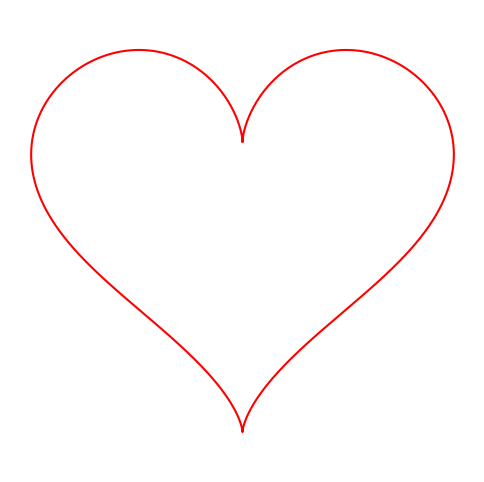

In [6]:

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 2 * np.pi, 1000)
x = 16 * np.sin(t)**3
y = 13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t)

plt.figure(figsize=(6, 6))
plt.plot(x, y, color='red')
plt.axis('equal')
plt.axis('off')
plt.show()

In [25]:
from pinecone import Pinecone

# Initialize Pinecone
pinecone_index_name = "langchain-index"
pc = Pinecone(pinecone_api_key=pinecone_api_key)
# pc.create_index("my_index")

if pc.describe_index("langchain-index").get("status", {}).get("state") != "Ready":
    print("Index is not ready yet. Please wait for a few minutes.")
else:
    print("Index is ready for use.")

index = pc.Index(pinecone_index_name)

pc.delete_index(pinecone_index_name)

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\pault\\anaconda3\\envs\\app_project\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone


Index is ready for use.


> Complete code to run it without our API

In [8]:
import os
import openai
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.vectorstores import Chroma


from langchain_openai import OpenAI as LangchainOpenAI
from langchain_openai import ChatOpenAI as LangchainChatOpenAI 
from langchain.chains import RetrievalQA
# from langchain.vectorstores import Pinecone
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from uuid import uuid4
from langchain.chains import ConversationalRetrievalChain

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory


from src.rag.document_loader import URLDocumentLoader, FileDocumentLoader, GitHubIssuesDocumentLoader, GitHubRepoDocumentLoader, ResearchPapersDocumentLoader
from src.rag.text_splitter import TextSplitter
from src.rag.document_loader import FileDocumentLoader


datasets = FileDocumentLoader().load_from_files([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')]) # Load data from text files
splitter = TextSplitter(splitter_type = 'recursive', chunk_size = 1000, chunk_overlap = 200)
# split files into chunks
datas_chunks = splitter.split_file_documents([os.path.join(os.getcwd(), 'data', file) for file in os.listdir('data')])

#---------------------Vector Store---------------------
embeddings = OpenAIEmbeddings(
                model="text-embedding-ada-002",  # You can make this configurable
                # disallowed_search=(),
                openai_api_key=openai_api_key
            )
dummy_vector = embeddings.embed_query("test dimension")
dimension = len(dummy_vector)

pc = Pinecone(pinecone_api_key=pinecone_api_key)
pinecone_index_name = "langchain-index"
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
if pinecone_index_name not in existing_indexes:
    pc.create_index(
            name=pinecone_index_name,
            dimension=dimension,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region="us-east-1")
        )

index = pc.Index(pinecone_index_name)
vector_store = PineconeVectorStore(index=index, embedding=embeddings)
ids = [str(uuid4()) for _ in range(len(datas_chunks))]
vector_store.add_documents(documents=datas_chunks, ids=ids)
retriever = vector_store.as_retriever()


#---------------------RAG Pipeline---------------------
llm = LangchainChatOpenAI(api_key=openai_api_key, model="gpt-4")



# System instructions
system_template = """
You are a helpful assistant with access to the following context.

{context}

Follow these rules:
1. If the answer is not in the context, say "I don't know".
2. Keep your answer brief, under three sentences.
"""

# We can build a chat prompt that includes:
#  - System message template
#  - A placeholder for conversation history
#  - A user question
chat_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_template),
    # MessagesPlaceholder(variable_name="history"),  # Will hold conversation memory
    HumanMessagePromptTemplate.from_template("{question}")
])




memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    input_key="question",
    output_key="answer"
)

# Pass the `chat_prompt` as the "combine_docs_chain" argument
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,              # Optionally see which docs were used
    combine_docs_chain_kwargs={"prompt": chat_prompt}
)

# chat_history = []

user_query = input("User: ")
if user_query.lower() in ["exit", "quit"]:
    print("Exiting the chat.")

# The chain expects a dict with {"question": <user query>} 
result = conversation_chain({"question": user_query})

# "answer" is the final text from the LLM
print("Assistant:", result["answer"])
print(result["source_documents"])


INFO:src.rag.text_splitter:Loading file documents from paths: ['c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\1206.4612v1.pdf', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Cost-Sensitive_Online_Classification.pdf', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Cytovance data.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Innovation District Student Interview Questions.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\licence-plate-detection', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\LLM App\\data\\Manuscript_template.docx', 'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\P